In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import arviz as az
import seaborn as sns

from REStats.utils import load_SCADA, transform, inv_transform, downsample
from REStats.circular_metrics import circular_rmse, circular_mae, circular_mean, circular_residuals
from REStats.models import wind_speed, weibull, wind_dir
from REStats.plots import save_figs, plot_circular_histogram

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [2]:
sns.set_theme()

In [3]:
wt = load_SCADA(2019)

In [4]:
SAVE_FIGS = True
figs = {}

# Wind -> Wind

This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data before passing it to the model.

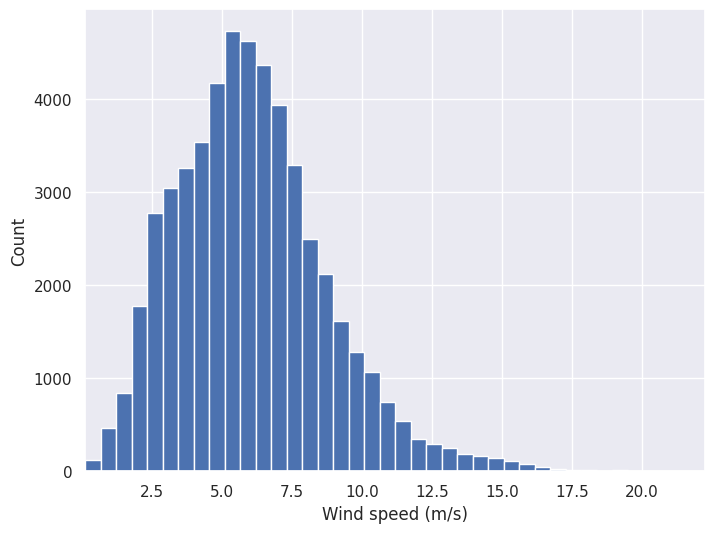

In [5]:
full_ws_hist, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Count")

b = ax.hist(wt.wind_speed, bins=40)

figs["full_ws_hist"] = full_ws_hist

In [6]:
wt_1m = wt[(wt.index >= "2019-02-01") & (wt.index < "2019-03-01")]

wt_ds = downsample(wt_1m) 

ws = wt_ds[["wind_speed"]]

/home/cam/workspace/projects/REStats/REStats/utils.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["turbulence_intensity"] = (


In [7]:
wt_ds.isnull().sum()

wind_speed              0
wind_dir                0
power                   0
turbulence_intensity    0
dtype: int64

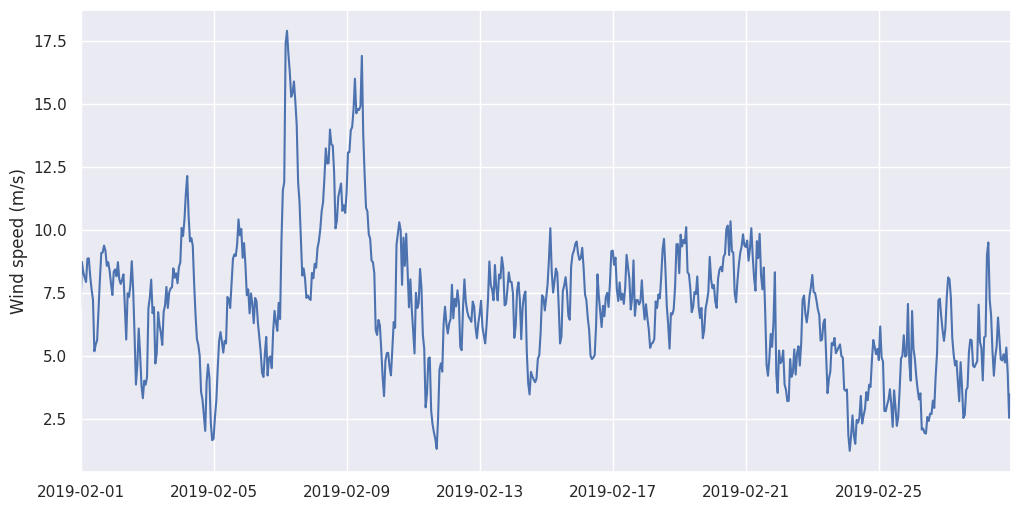

In [8]:
training_raw, ax = plt.subplots(figsize=(12, 6))

ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(wt_ds.index, wt_ds.wind_speed)

figs["training_raw"] = training_raw

## Modeling: Wind Speed Distribution

In order to transform the wind speed distribution to be more Normal, fit the current distribution as Weibull using Bayesian Inference. The resulting shape parameter, $\alpha$, will be used to perform the transformation.

In [9]:
idata_wb = weibull.fit(wt_ds.wind_speed)

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [0]: 100%|█| 1500/1500 [00:19, 77.34it/s, step size=7.92e-01, acc. prob=0
Sample [1]: 100%|█| 1500/1500 [00:17, 86.80it/s, step size=9.06e-01, acc. prob=0


In [10]:
wt_ds.wind_speed.describe()

count    672.000000
mean       6.926740
std        2.713543
min        1.224047
25%        5.091319
50%        6.937040
75%        8.325460
max       17.903056
Name: wind_speed, dtype: float64

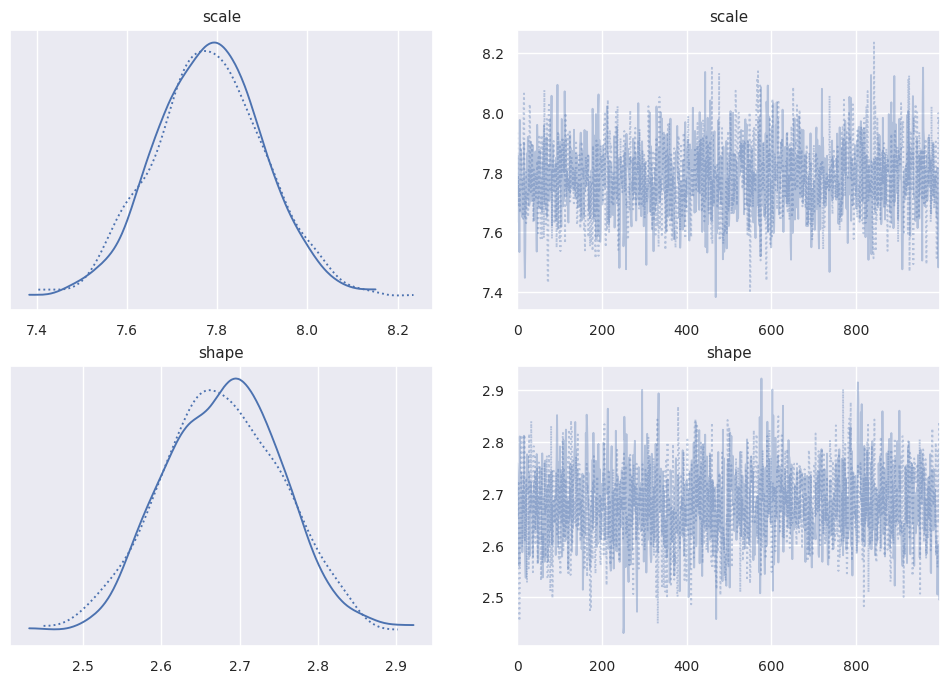

In [11]:
az.plot_trace(idata_wb, figsize=(12, 8))

wb_trace = plt.gcf()
figs["wb_trace"] = wb_trace

In [12]:
az.loo(idata_wb)

Computed from 2000 posterior samples and 672 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1615.37    21.20
p_loo        2.73        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      672  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [13]:
idata_wb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

/home/cam/workspace/projects/REStats/REStats/models/weibull.py:110: RuntimeWarning: divide by zero encountered in power
  * (x / scale) ** (shape - 1)


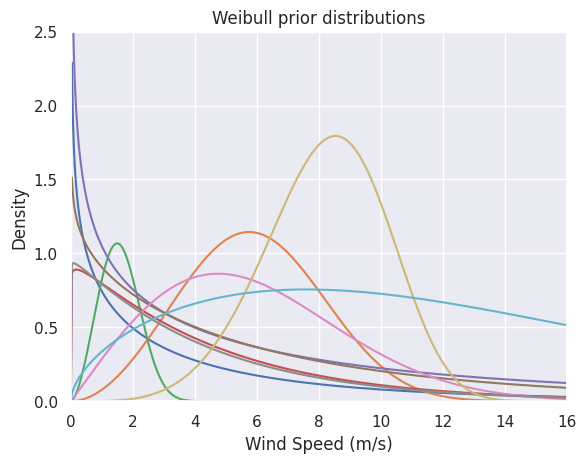

In [14]:
fig = weibull.plot_prior_samples(idata_wb)
    
figs["wb_prior"] = fig

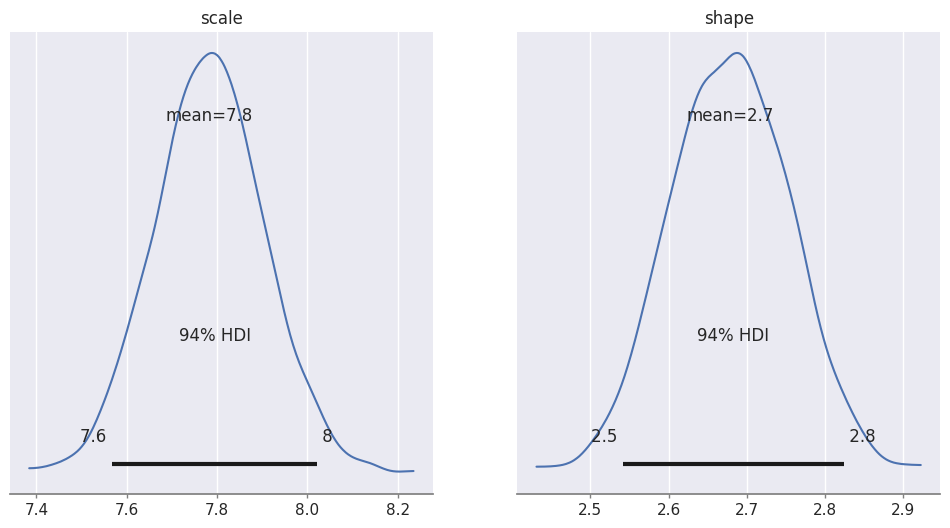

In [15]:
az.plot_posterior(idata_wb, figsize=(12, 6))

wb_posterior = plt.gcf()

figs["wb_posterior"] = wb_posterior

In [16]:
# wb_ppc, ax = plt.subplots(figsize=(8, 6))

# az.plot_ppc(idata_wb, ax=ax)
# ax.set_xlabel("Wind speed (m/s)")

# figs["wb_ppc"] = wb_ppc

We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

In [17]:
shape, scale = weibull.get_params(idata_wb)
m = weibull.calc_m(shape)

print(f"m: {m}")

m: 0.7439951038442394


In [18]:
ws_tf, hr_stats = transform(ws, m)

ws_tf.head()

,wind_speed,v_scaled,v,hr,v_scaled_std
Date,,,,,
2019-02-01 00:00:00,6.851252,4.186092,6.851252,0,-0.017796
2019-02-01 01:00:00,8.726291,5.011557,8.726291,1,0.667085
2019-02-01 02:00:00,8.323363,4.838356,8.323363,2,0.474752
2019-02-01 03:00:00,8.106309,4.744167,8.106309,3,0.336597
2019-02-01 04:00:00,7.925400,4.665169,7.925400,4,0.198638


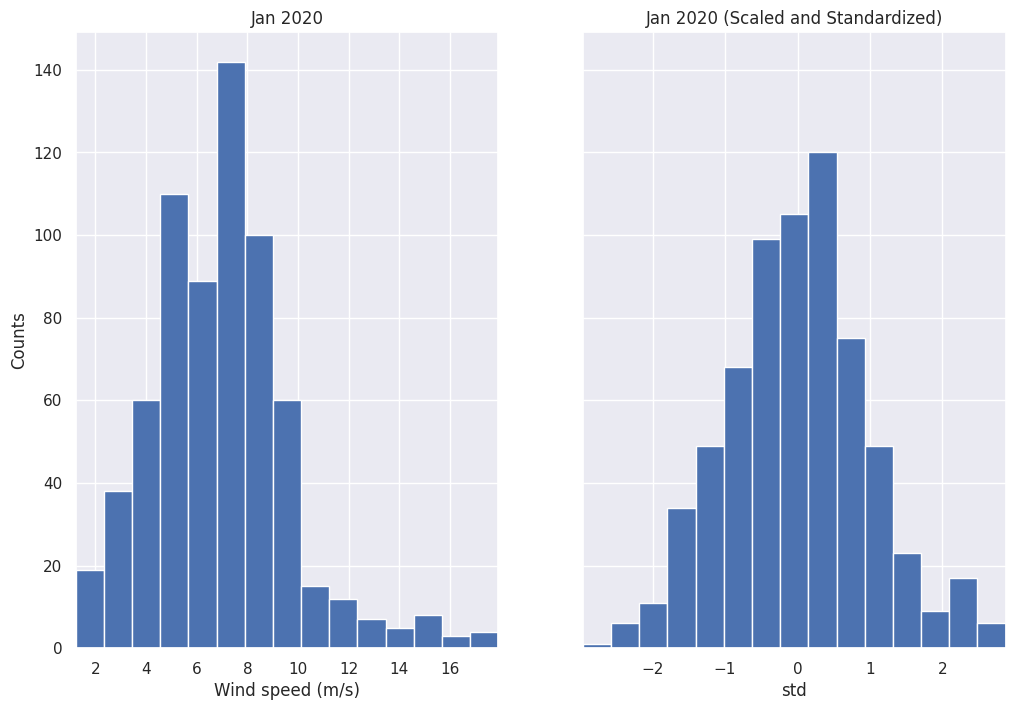

In [19]:
ws_hist_std_comparison, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

[ax.set_xmargin(0) for ax in axes]
axes[0].set_ylabel("Counts")
axes[0].hist(ws_tf.v, bins=15)
axes[0].set_title("Jan 2020")
axes[0].set_xlabel("Wind speed (m/s)")
axes[1].hist(ws_tf.v_scaled_std, bins=15)
axes[1].set_title("Jan 2020 (Scaled and Standardized)")
axes[1].set_xlabel("std")

figs["ws_hist_std_comparison"] = ws_hist_std_comparison

## Modeling: Wind Speed

Autoregressive Moving Average (ARMA) models combine autoregression (AR) and moving average (MA) terms in order to best fit the time series. The ARMA(2, 2) model has been shown in the literature to be highly competitive for short-term wind speed forecasting, though other combinations of p (AR lags) and q (MA lags) may prove better depending on the situation.

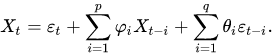

The data transformation includes both the scaling based on Weibull fit, as well as standardization based on mean/std wind speeds for given hours of the day, which helps remove diurnal nonstationarity.

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


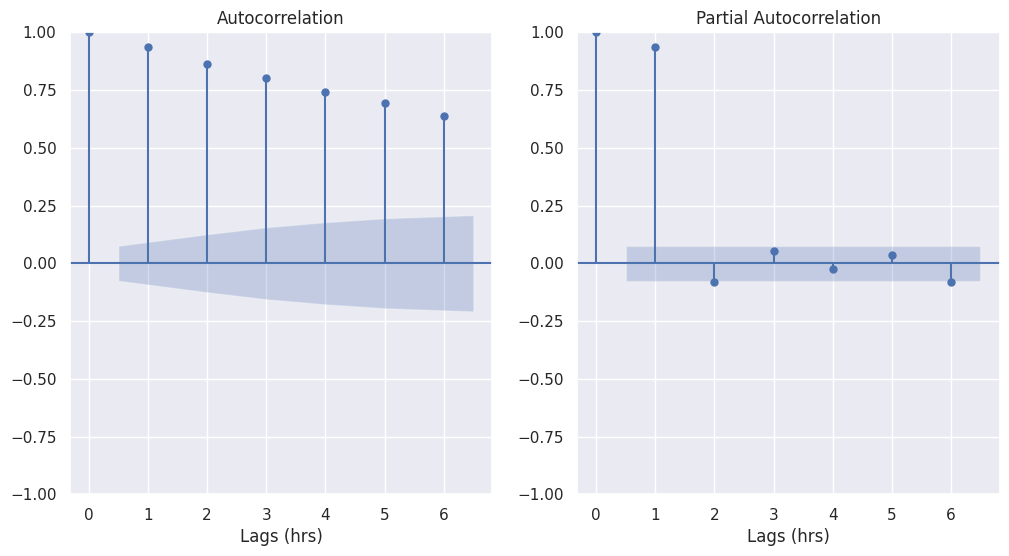

In [20]:
autocorrelation, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_xlabel("Lags (hrs)")
axes[1].set_xlabel("Lags (hrs)")

autocorrelation = plot_acf(wt_ds.wind_speed, lags=6, ax=axes[0])
autocorrelation = plot_pacf(wt_ds.wind_speed, lags=6, ax=axes[1])

figs["acf_ws"] = autocorrelation

In [21]:
arma_mod = ARIMA(ws_tf.v_scaled_std, order=(2, 0, 2), trend="n")
arma_res = arma_mod.fit()
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:           v_scaled_std   No. Observations:                  672
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -272.577
Date:                Thu, 11 May 2023   AIC                            555.154
Time:                        23:00:37   BIC                            577.705
Sample:                    02-01-2019   HQIC                           563.888
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4977      0.270      1.842      0.066      -0.032       1.027
ar.L2          0.4088      0.245      1.668      0.095      -0.071       0.889
ma.L1          0.4617      0.271      1.706      0.0

In [22]:
pred = arma_res.get_prediction().summary_frame()
pred = pred.copy()
pred

v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2019-02-01 00:00:00,0.000000,0.982940,-1.926526,1.926526
2019-02-01 01:00:00,-0.016526,0.364675,-0.731276,0.698224
2019-02-01 02:00:00,0.634903,0.364568,-0.079637,1.349444
2019-02-01 03:00:00,0.376830,0.363042,-0.334721,1.088380
2019-02-01 04:00:00,0.356957,0.362689,-0.353901,1.067814
...,...,...,...,...
2019-02-28 19:00:00,-0.615730,0.362462,-1.326142,0.094681
2019-02-28 20:00:00,-1.104054,0.362462,-1.814465,-0.393642
2019-02-28 21:00:00,-0.804085,0.362462,-1.514497,-0.093674


Reverse the transformations for error calculations and plotting.

In [23]:
inv_pred = inv_transform(pred, m, hr_stats)
arma_rmse = mean_squared_error(ws_tf.v, inv_pred["mean"], squared=False)
arma_rmse_rel = arma_rmse/ws_tf.v.mean()*100

arma_mae = mean_absolute_error(ws_tf.v, inv_pred["mean"])

print(f"ARMA(2, 2) RMSE: {arma_rmse} m/s")
print(f"ARMA(2, 2) RMSE (%): {arma_rmse_rel}")
print(f"ARMA(2, 2) MAE: {arma_mae} m/s")

ARMA(2, 2) RMSE: 0.922384112078709 m/s
ARMA(2, 2) RMSE (%): 13.316281048334625
ARMA(2, 2) MAE: 0.7127466144490445 m/s


In [24]:
per = ws_tf.v.shift(1).bfill()
per_rmse = mean_squared_error(ws_tf.v, per, squared=False)
per_rmse_rel = per_rmse/ws_tf.v.mean()*100
per_mae = mean_absolute_error(ws_tf.v, per)

print(f"PER RMSE: {per_rmse} m/s", per_rmse)
print(f"PER RMSE (%): {per_rmse_rel}")
print(f"PER MAE: {per_mae} m/s")

PER RMSE: 0.9755607840147397 m/s 0.9755607840147397
PER RMSE (%): 14.083982377360604
PER MAE: 0.7487402425714988 m/s


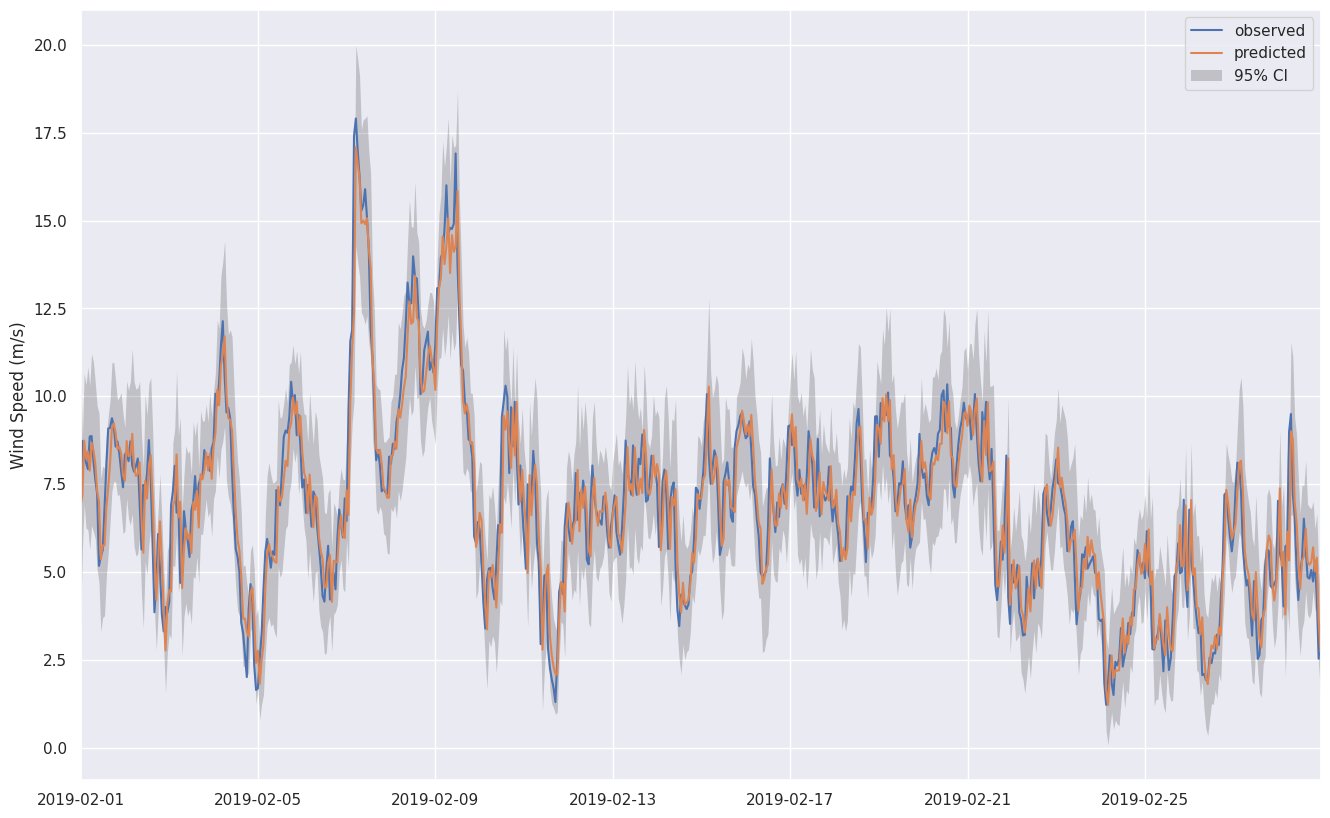

In [25]:
arma_fit_results, ax = plt.subplots(figsize=(16, 10))

ax.set_xmargin(0)
ax.set_ylabel("Wind Speed (m/s)")

ax.plot(ws_tf.index, ws_tf.v, label="observed")

ax.plot(inv_pred.index, inv_pred["mean"], label="predicted")
ax.fill_between(
    inv_pred.index, 
    inv_pred.mean_ci_lower, 
    inv_pred.mean_ci_upper, 
    color="k", alpha=.2, linewidth=0,
    label="95% CI"
)

ax.legend()

figs["arma_fit_results"] = arma_fit_results

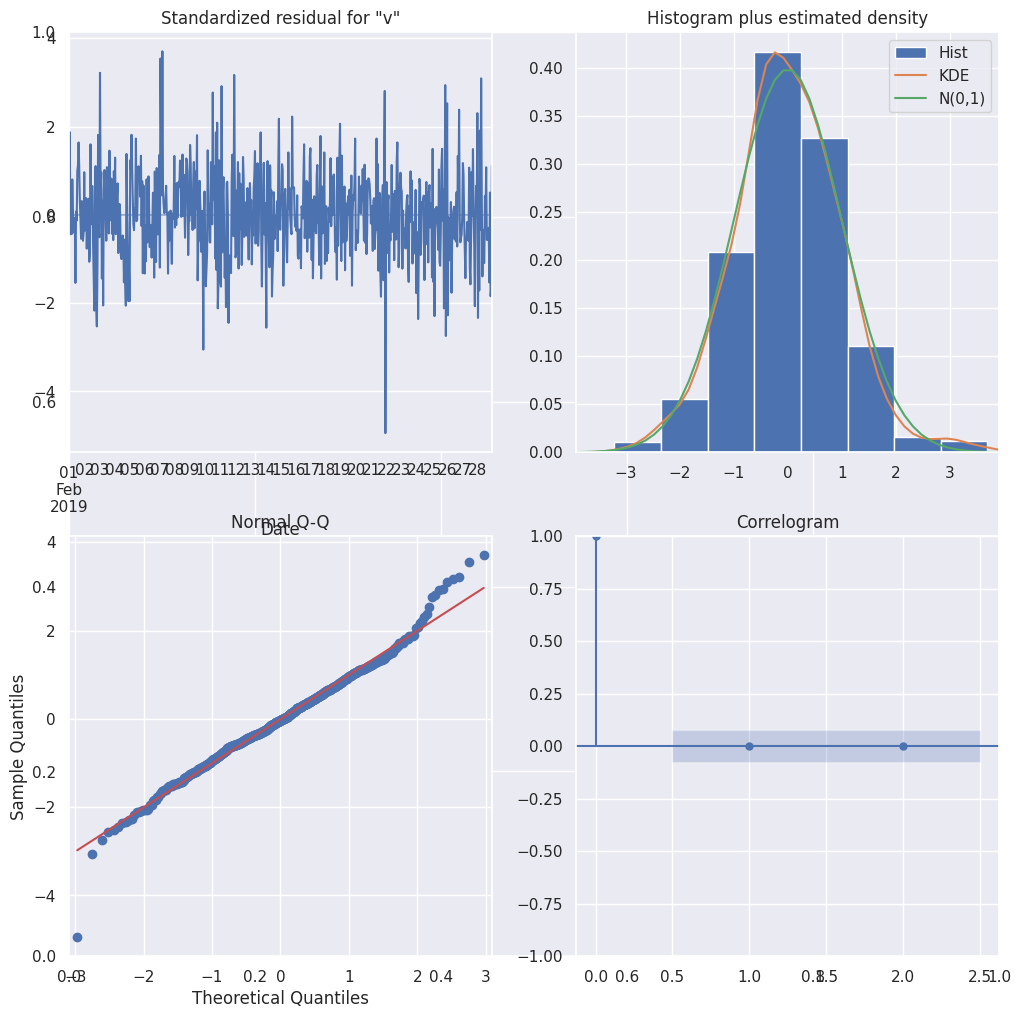

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))

f = arma_res.plot_diagnostics(fig=fig, lags=2)

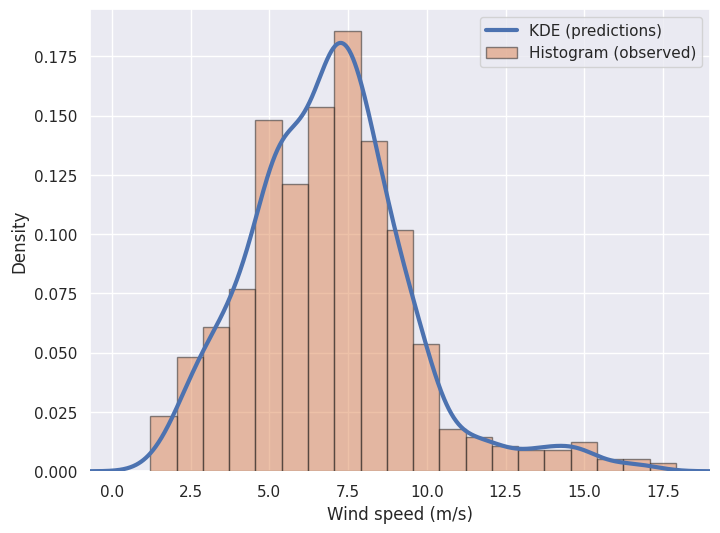

In [27]:
kde = sm.nonparametric.KDEUnivariate(inv_pred["mean"])
kde.fit()  # Estimate the densities

arma_fit_kde, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Density")

ax.plot(kde.support, kde.density, lw=3, label="KDE (predictions)", zorder=10)
ax.hist(
    ws_tf.v,
    bins=20,
    density=True,
    label="Histogram (observed)",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)
ax.legend()

figs["arma_fit_kde"] = arma_fit_kde

## Forecast: Wind Speed

In [28]:
wt_train = wt[(wt.index >= "2019-02-01") & (wt.index < "2019-03-01")].copy()
wt_test = wt[(wt.index >= "2019-03-01") & (wt.index < "2019-04-01")].copy()

wt_train = downsample(wt_train)
wt_test = downsample(wt_test)

v_train = wt_train[["wind_speed"]]
v_test = wt_test[["wind_speed"]]

In [29]:
forecasts_full, _ = wind_speed.backtest(v_train, v_test, idata_wb=idata_wb)


Results for step size: 1
Forecast RMSE: 1.1152087723033515 m/s
Forecast RMSE (%): 14.639006757302148
Forecast MAE: 0.830884264565636 m/s


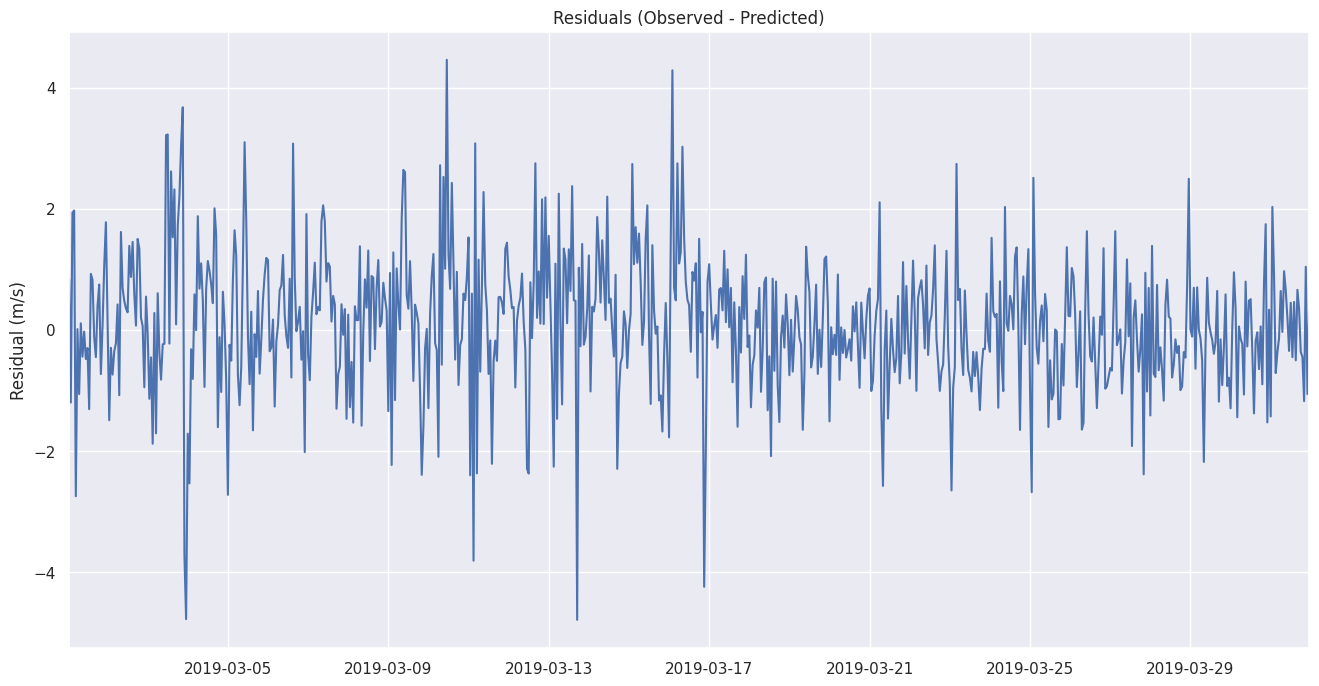

In [30]:
arma_forecast_resid, ax = plt.subplots(figsize=(16, 8))
ax.set_ylabel("Residual (m/s)")
ax.set_xmargin(0)
ax.set_title("Residuals (Observed - Predicted)")

resid = v_test["wind_speed"][1:] - forecasts_full["mean"]

ax.plot(forecasts_full.index, resid)

figs["arma_forecast_resid"] = arma_forecast_resid

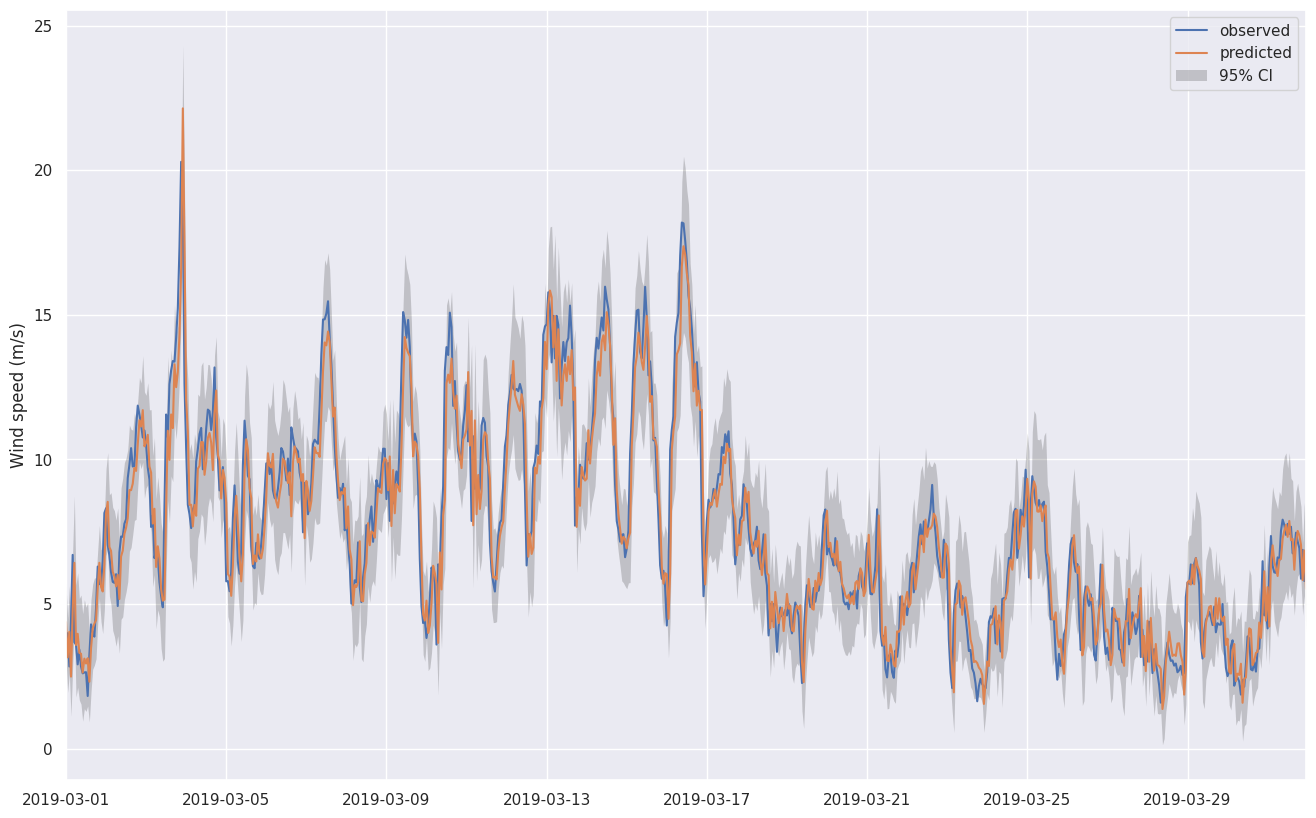

In [31]:
arma_forecast_results, ax = plt.subplots(figsize=(16, 10))
ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(v_test.index[1:], v_test[1:], label="observed")
ax.plot(forecasts_full.index, forecasts_full["mean"], label="predicted")


ax.fill_between(
    forecasts_full.index, 
    forecasts_full.mean_ci_lower, 
    forecasts_full.mean_ci_upper,
    color="k", alpha=.2, linewidth=0, label="95% CI"
)

ax.legend()

figs["arma_forecast_results"] = arma_forecast_results

In [32]:
dtype = np.dtype([("rmse", float), ("rmse_rel", float), ("mae", float)])

err_fcast = np.empty(6, dtype=dtype)
err_per = np.empty(6, dtype=dtype)

for i in range(6):
    _, err_f = wind_speed.backtest(v_train, v_test, idata_wb=idata_wb, steps=i+1)
    err_fcast[i] = err_f
    _, err_p = wind_speed.calc_persistence(v_test["wind_speed"], steps=i+1)
    err_per[i] = err_p


Results for step size: 1
Forecast RMSE: 1.1152087723033515 m/s
Forecast RMSE (%): 14.639006757302148
Forecast MAE: 0.830884264565636 m/s
PER RMSE: 1.0878713081455473 m/s
PER RMSE (%): 14.268762405169083
PER MAE: 0.7957124884609722 m/s

Results for step size: 2
Forecast RMSE: 1.4185739333847158 m/s
Forecast RMSE (%): 18.62118906548807
Forecast MAE: 1.0524473454356913 m/s
PER RMSE: 1.3980906707624878 m/s
PER RMSE (%): 18.337668667813066
PER MAE: 0.9808483069874635 m/s

Results for step size: 3
Forecast RMSE: 1.5820848757574673 m/s
Forecast RMSE (%): 20.767547531933534
Forecast MAE: 1.171725855012729 m/s
PER RMSE: 1.6824082230111825 m/s
PER RMSE (%): 22.066841015938916
PER MAE: 1.1999031449500928 m/s

Results for step size: 4
Forecast RMSE: 1.8027548261980766 m/s
Forecast RMSE (%): 23.664214932568814
Forecast MAE: 1.327682784397919 m/s
PER RMSE: 1.819715358492058 m/s
PER RMSE (%): 23.867791990600388
PER MAE: 1.3040926403505184 m/s

Results for step size: 5
Forecast RMSE: 2.09832259584881

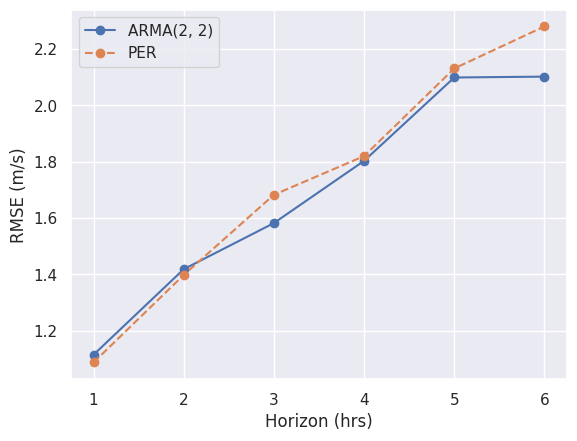

In [33]:
fig, ax = plt.subplots()
# ax.set_xmargin(0)

ax.set_xlabel("Horizon (hrs)")
ax.set_ylabel("RMSE (m/s)")
ax.plot(range(1, len(err_fcast) + 1), [e[0] for e in err_fcast], marker="o", label="ARMA(2, 2)")
ax.plot(range(1, len(err_per) + 1), [e[0] for e in err_per], linestyle="--", marker="o", label="PER")
ax.legend()

figs["ws_arma_per"] = fig

## Modeling: Wind Direction

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


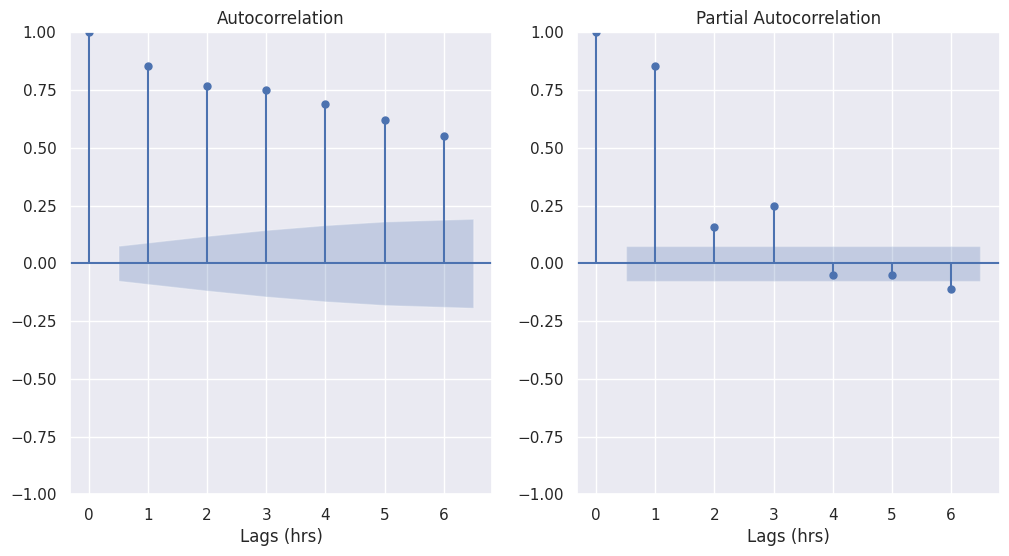

In [34]:
autocorrelation, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_xlabel("Lags (hrs)")
axes[1].set_xlabel("Lags (hrs)")

autocorrelation = plot_acf(wt_ds.wind_dir, lags=6, ax=axes[0])
autocorrelation = plot_pacf(wt_ds.wind_dir, lags=6, ax=axes[1])

figs["acf_wind_dir"] = autocorrelation

In [35]:
# Forecast wind_dir using the persistence method
steps_ahead = 1
wind_dir_per, _ = wind_dir.calc_persistence(wt_ds.wind_dir, steps_ahead)

PER RMSE: 13.083652163395339 deg
PER RMSE (%): 6.120348820940454
PER MAE: 8.117602037160141 deg


In [36]:
# Load your wind direction data as a 1D array (e.g., a numpy array or a pandas Series)
wind_dir_data = wt_ds.wind_dir.values

sin_model, cos_model = wind_dir.fit(wind_dir_data)
res = wind_dir.predict(sin_model, cos_model, wind_dir_data)
res

,wind_dir_pred,wind_dir_obs,lower_bound,upper_bound
0,215.455009,62.316973,298.574371,158.468371
1,62.309702,52.220494,35.696701,83.184759
2,49.239907,47.412911,24.827685,71.951375
3,46.577506,53.989870,22.332515,69.881148
4,56.208787,50.168086,30.561070,77.797084
...,...,...,...,...
667,269.957398,286.072572,282.583773,247.104045
668,290.398866,300.330975,297.183439,275.493672
669,302.155611,308.103162,305.571231,293.960965
670,307.997938,322.534348,309.698375,303.785428


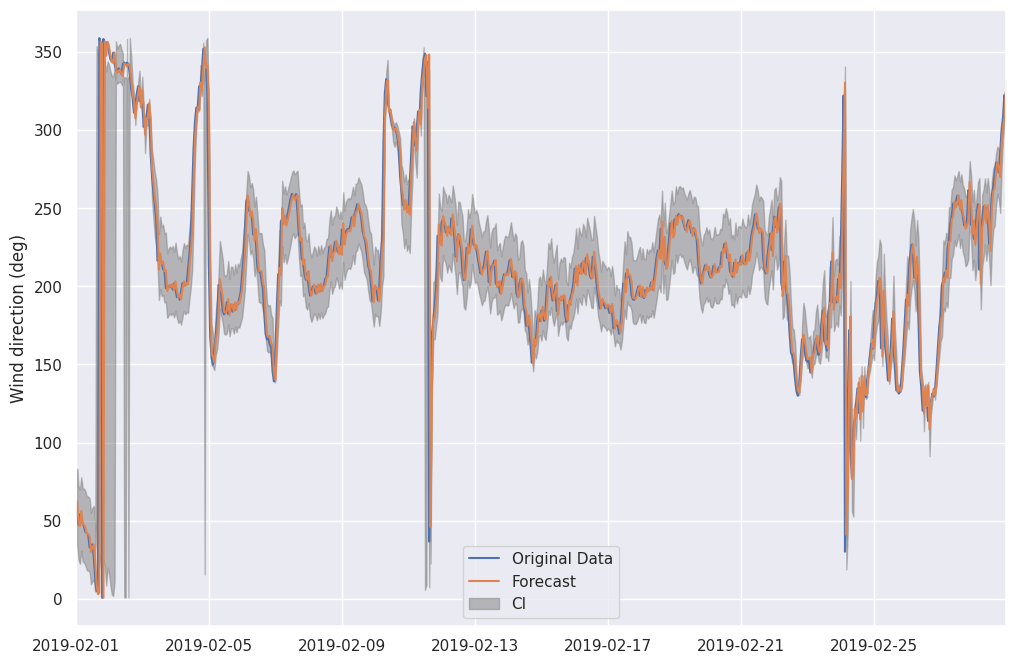

In [37]:
# Plot the forecasts and CI intervals
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xmargin(0)
ax.set_ylabel("Wind direction (deg)")
ax.plot(wt_ds.index, wind_dir_data, label="Original Data")
ax.plot(wt_ds.index[1:],
         res.wind_dir_pred[1:], label="Forecast")
ax.fill_between(wt_ds.index[1:],
                 res.lower_bound[1:], res.upper_bound[1:], color="gray", alpha=0.5, label="CI")
ax.legend()

figs["wd_pred"] = fig

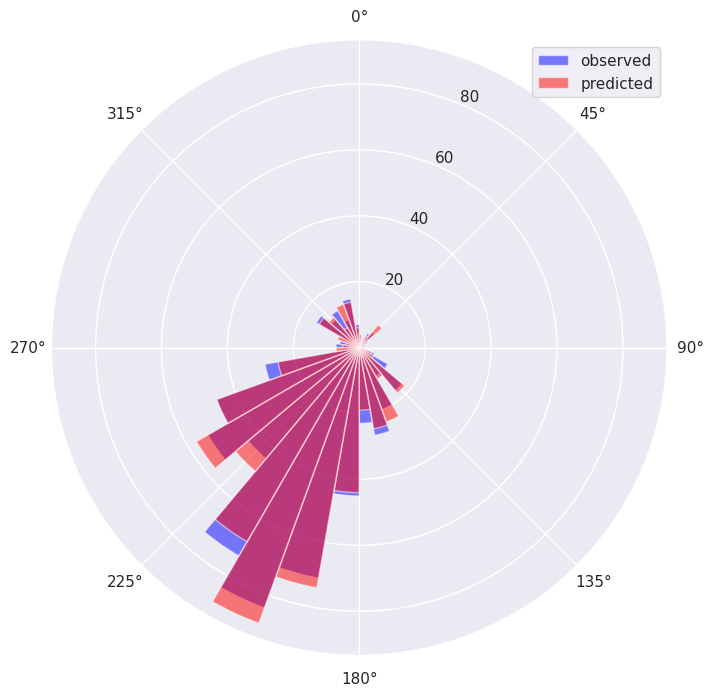

In [38]:
fig = plot_circular_histogram(res.wind_dir_obs, res.wind_dir_pred)

figs["wd_pred_hist"] = fig

## Forecast: Wind Direction

In [39]:
wd_train = wt_train.wind_dir
wd_test = wt_test.wind_dir

In [40]:
wind_dir_per, _ = wind_dir.calc_persistence(wd_test, steps=1)

PER RMSE: 13.867006931471707 deg
PER RMSE (%): 5.499792873539658
PER MAE: 8.645401803780475 deg


In [41]:
wd_fcast, _ = wind_dir.backtest(wd_train, wd_test)

wd_fcast


Results for step size: 1
Forecast RMSE: 13.061025683919441 deg
Forecast RMSE (%): 5.177758137171221
Forecast MAE: 8.31774552209911 deg


,mean,lower_ci,upper_ci
2019-03-01 00:00:00,313.017380,313.217833,312.507606
2019-03-01 01:00:00,343.563120,335.080648,0.790700
2019-03-01 02:00:00,338.679562,331.099902,355.900611
2019-03-01 03:00:00,301.047068,304.797219,292.072058
2019-03-01 04:00:00,309.060161,310.431568,305.695656
...,...,...,...
2019-03-31 19:00:00,46.899930,22.315985,70.413162
2019-03-31 20:00:00,53.875658,28.617384,75.841989
2019-03-31 21:00:00,75.097684,48.988647,92.140238
2019-03-31 22:00:00,78.730920,52.899029,94.812214


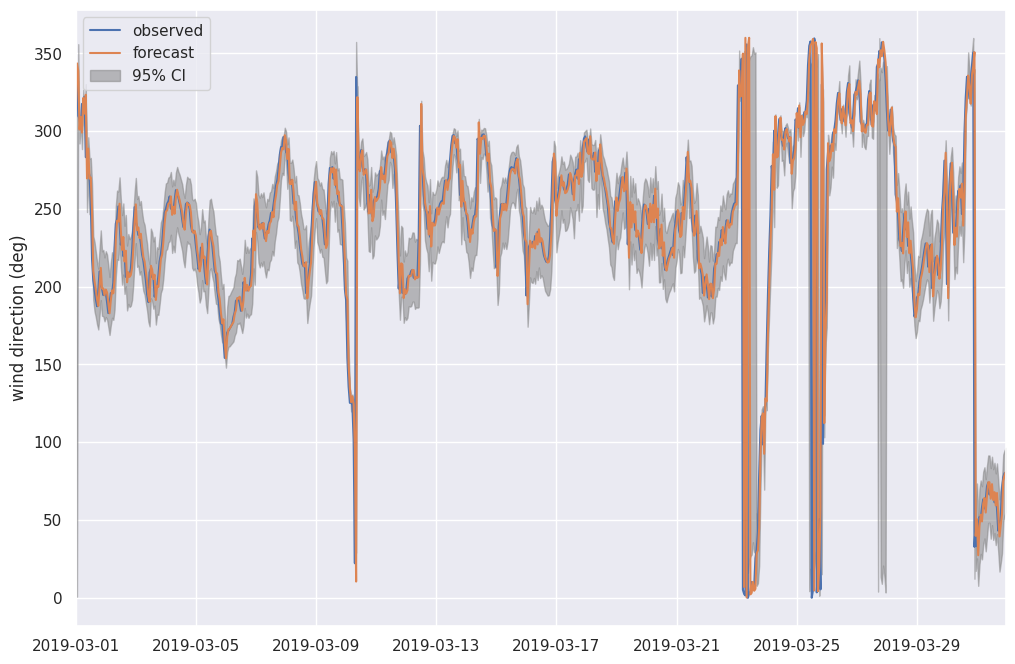

In [42]:
# Plot the forecasts and CI intervals
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xmargin(0)
ax.set_ylabel("wind direction (deg)")
ax.plot(wd_test.index, wd_test, label="observed")
ax.plot(wd_test.index,
         wd_fcast["mean"], label="forecast")
ax.fill_between(wd_test.index,
                 wd_fcast.lower_ci, wd_fcast.upper_ci, color="gray", alpha=0.5, label="95% CI")
ax.legend()

figs["wd_fcast"] = fig

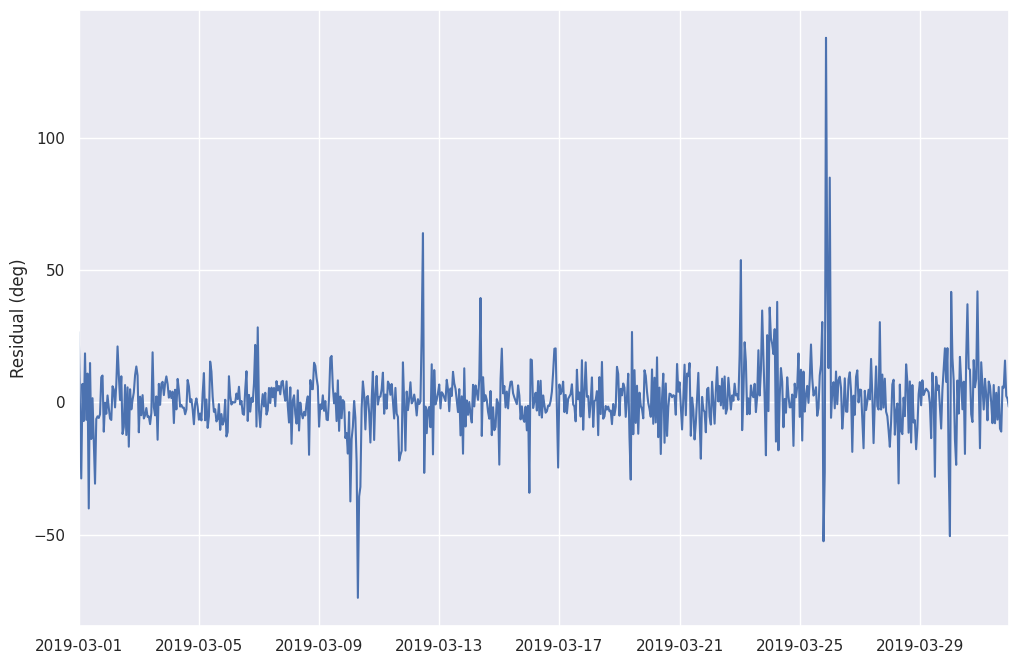

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xmargin(0)
ax.set_ylabel("Residual (deg)")

ax.plot(wd_test.index, circular_residuals(wd_test, wd_fcast["mean"]))

figs["wd_resid"] = fig

In [44]:
dtype = np.dtype([("rmse", float), ("rmse_rel", float), ("mae", float)])

err_fcast = np.empty(6, dtype=dtype)
err_per = np.empty(6, dtype=dtype)

for i in range(6):
    _, err_f = wind_dir.backtest(wd_train, wd_test, steps=i+1)
    err_fcast[i] = err_f
    _, err_p = wind_dir.calc_persistence(wd_test, steps=i+1)
    err_per[i] = err_p


Results for step size: 1
Forecast RMSE: 13.061025683919441 deg
Forecast RMSE (%): 5.177758137171221
Forecast MAE: 8.31774552209911 deg
PER RMSE: 13.867006931471707 deg
PER RMSE (%): 5.499792873539658
PER MAE: 8.645401803780475 deg

Results for step size: 2
Forecast RMSE: 17.019094773606007 deg
Forecast RMSE (%): 6.746848110085242
Forecast MAE: 11.152361114893704 deg
PER RMSE: 18.910866058949065 deg
PER RMSE (%): 7.500237570908383
PER MAE: 11.450661143994497 deg

Results for step size: 3
Forecast RMSE: 21.754983120512993 deg
Forecast RMSE (%): 8.624287525515095
Forecast MAE: 13.517273639710556 deg
PER RMSE: 22.31895388484931 deg
PER RMSE (%): 8.851919100304876
PER MAE: 13.913637493048714 deg

Results for step size: 4
Forecast RMSE: 24.868375467135635 deg
Forecast RMSE (%): 9.858523867059022
Forecast MAE: 15.94868229716819 deg
PER RMSE: 24.95936052053469 deg
PER RMSE (%): 9.89913063412417
PER MAE: 16.142236107269074 deg

Results for step size: 5
Forecast RMSE: 26.91257998397433 deg
Fore

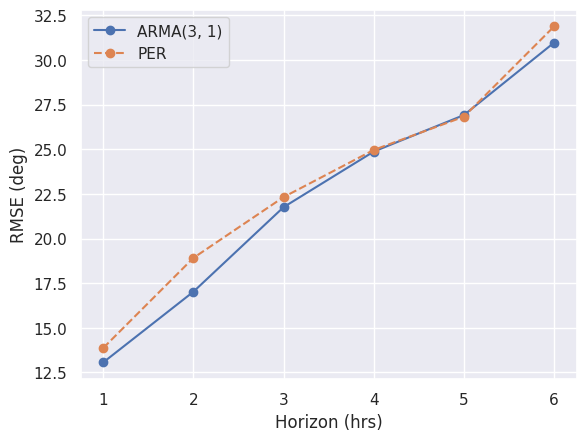

In [45]:
fig, ax = plt.subplots()
# ax.set_xmargin(0)

ax.set_xlabel("Horizon (hrs)")
ax.set_ylabel("RMSE (deg)")
ax.plot(range(1, len(err_fcast) + 1), [e[0] for e in err_fcast], marker="o", label="ARMA(3, 1)")
ax.plot(range(1, len(err_per) + 1), [e[0] for e in err_per], linestyle="--", marker="o", label="PER")
ax.legend()

figs["wd_arma_per"] = fig

In [46]:
if SAVE_FIGS:
    save_figs(figs)